In [9]:
library(ape)
library(tidyverse)
library(glue)

library(phytools)

# library(caper)
library(lme4)
library(lmerTest)
library(lmtest)


# library(LaplacesDemon) # documentation: https://rdrr.io/cran/phyr/man/pglmm.html
library(ggplot2)
# library(ggpubr)
# library(rstatix)
library(DHARMa)
# library(betareg)

source("../../../code/feature_computation/utils.R")
library(pbmcapply)
library(vegan)

# library(caTools)
library(car)
# library(quantmod)
library(MASS)
# library(corrplot)
library(performance)
library(comprehenr)

options(xts.warn_dplyr_breaks_lag = FALSE)

In [10]:
# need to use beta distribution for all variables distributed between 0 and 1
# https://stats.stackexchange.com/questions/508023/which-link-function-could-be-used-for-a-glm-where-the-response-is-per-cent-0
# https://rpubs.com/nicoleknight/936037

test_ploidy_freq_effect <- function(response_var){
    fixed_covars = c("is_polyploid_poly_frac")
    random_covars = c("network_size", "pd")
    
    fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
    random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
    complete_formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
    
    res_df <- data.frame(matrix(ncol = 5, nrow = length(fixed_covars)+length(random_covars)+1))
    x <- c("response_variable", "variable", "type", "lrt_statistic", "lrt_pvalue")
    colnames(res_df) <- x
    res_df["response_variable"] = rep(response_var, length(fixed_covars)+length(random_covars)+1)
    res_df["variable"] = c(fixed_covars, random_covars, c("Intercept"))
    res_df["type"] = c(rep(c("fixed"), length(fixed_covars)), rep(c("random"), length(random_covars)), c("none"))
    rownames(res_df) <-res_df$variable
    res_df$variable <- NULL
    print(complete_formula_str)
    complete_formula = as.formula(complete_formula_str)
    
    model.full <- lmer(formula=complete_formula, 
                 , data=data
                 )
    model_res = summary(model.full)
    print(model_res)
    res = simulateResiduals(model.full)
    plot(res, asFactor = T)
    
    fixed_vars_res = as.data.frame(model_res$coefficients)
    rownames(fixed_vars_res) = to_vec(for (item in rownames(fixed_vars_res)) gsub('[^[:alpha:]^_]', '', item))
    colnames(fixed_vars_res) =  c("coefficient", "standard_error", "z_test_statistic", "z_test_pvalue")
    res_df = merge(res_df, fixed_vars_res, by=0, all=T)
    rownames(res_df) <-res_df$Row.names
    res_df$Row.names <- NULL
    
    for (fixed_var in fixed_covars)
    {
        subset_fixed_covars = ifelse(fixed_covars != fixed_var, fixed_covars, "")
        fixed_covars_formula_str = paste0(as.list(subset_fixed_covars), collapse = " + ")
        random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
        formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
        if (length(subset_fixed_covars) == 0)
            {
            formula_str = paste0(response_var, '~ ', random_covars_formula_str)
            }
        model.reduced <- lmer(formula=as.formula(formula_str), 
                 , data=data
                 )
        lrt <- anova(model.full, model.reduced)
        res_df[fixed_var, "lrt_statistic"] = lrt[2,"Chisq"]
        res_df[fixed_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
    }
                   
    for (random_var in random_covars)
    {
        if (random_var != "sample_id")
        {
            subset_random_covars = random_covars[which(random_covars != random_var)]
            fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
            random_covars_formula_str = paste0("(1|", paste0(as.list(subset_random_covars), collapse = ") + (1|"), ")")
            formula_str = paste0(response_var, ' ~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
            model.reduced <- lmer(formula=as.formula(formula_str)
                            , data=data
                            )
            lrt <- anova(model.full, model.reduced)
            res_df[random_var, "lrt_statistic"] = lrt[2,"Chisq"]
            res_df[random_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
        }
    }
    return (res_df)
}

In [12]:
# process data
weighted = TRUE
rewiring_prob = 0

max_missing_threshold = 0.5
min_classified_threshold = 10
min_poly_threhold = 5
min_di_threshold = 5

data_path <- glue('../../../data/statistical_analysis/extinction_analysis/rewiring_prob_{rewiring_prob}_aggregated_robustness_data.csv',
                 rewiring_prob=rewiring_prob)
data <- read.csv(data_path)
if (weighted) {
    data <- filter(data, network_type == "weighted")
} else
{
    data <- filter(data, network_type != "weighted")
}
data <- filter(data, is_polyploid_missing_frac <= max_missing_threshold & 
               num_classified >= min_classified_threshold &
               num_polyploids > min_poly_threhold & 
               num_diploids > min_di_threshold)
print(paste("# networks for analysis = ", nrow(data)))

[1] "# networks for analysis =  60"


# test for association between % ploidploids and robustness under random primary candidates selection

In [14]:
test_res = test_ploidy_freq_effect("random_robustness_mean")

[1] "random_robustness_mean~ is_polyploid_poly_frac + (1|network_size) + (1|pd)"


ERROR: Error in eval(predvars, data, env): object 'network_size' not found


In [105]:
round_df <- function(df, digits = 5) {
  nums <- vapply(df, is.numeric, FUN.VALUE = logical(1))

  df[,nums] <- round(df[,nums], digits = digits)

  (df)
}

round_df(test_res)

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue,NA
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,random_robustness,none,NA,NA,0.68767,0.00883,226.0477,77.90111,0.00000
is_polyploid_poly_frac,random_robustness,fixed,0.92791,0.33541,-0.01652,0.01715,192.7397,-0.96309,0.33671
network_size,random_robustness,random,42.93806,0.00000,NA,NA,NA,NA,NA
pd,random_robustness,random,3.67816,0.05513,NA,NA,NA,NA,NA


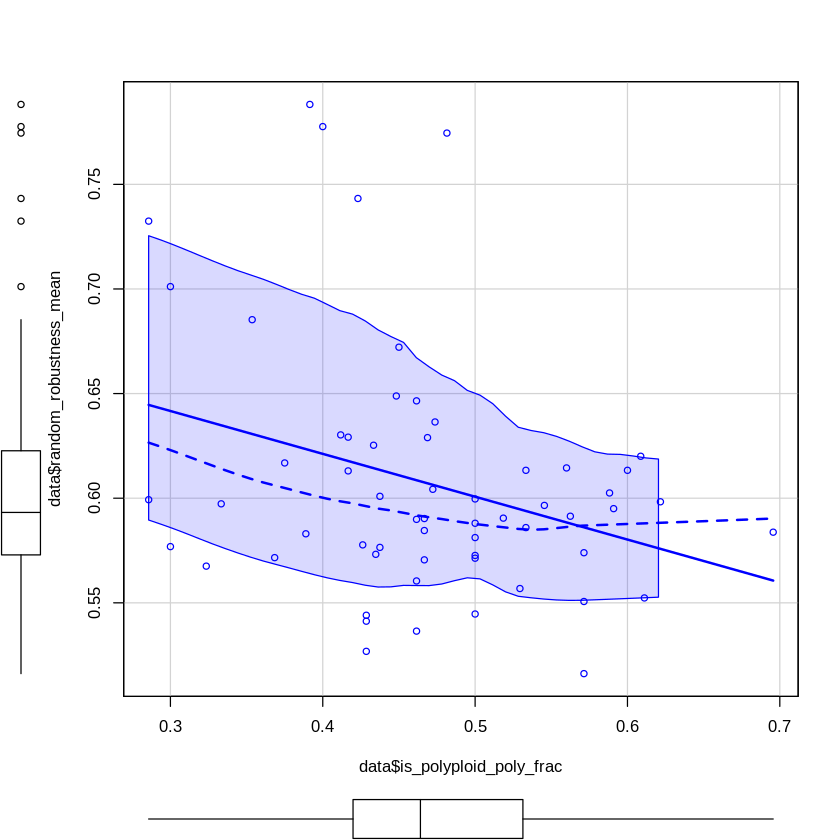

In [15]:
scatterplot(data$is_polyploid_poly_frac, data$random_robustness_mean)

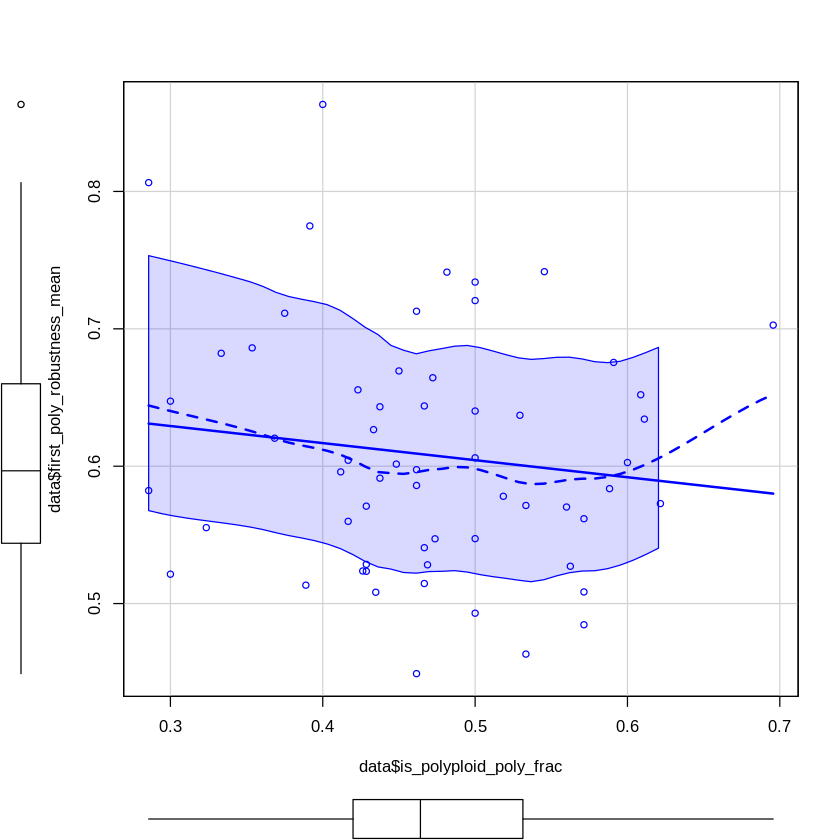

In [17]:
scatterplot(data$is_polyploid_poly_frac, data$first_poly_robustness_mean)

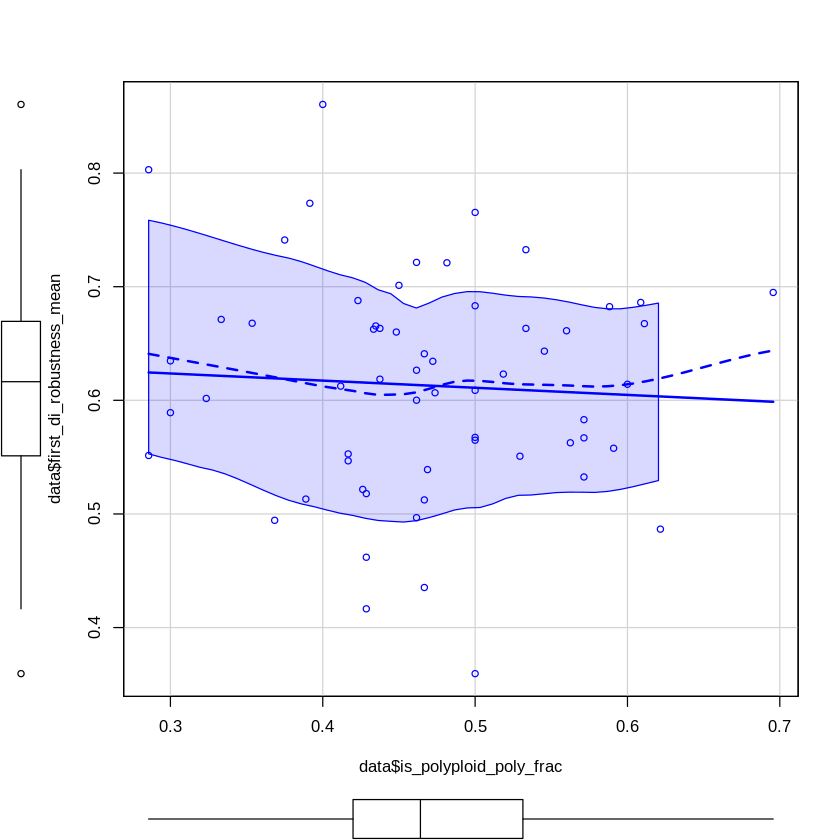

In [18]:
scatterplot(data$is_polyploid_poly_frac, data$first_di_robustness_mean)

# test for pairwise differences in robustness upon different primary extinction orders

## first polyploids vs. first diploids

In [16]:
wilcox.test(data$first_poly_robustness_mean, data$first_di_robustness_mean, paired = TRUE, alternative = "two.sided")


	Wilcoxon signed rank test with continuity correction

data:  data$first_poly_robustness_mean and data$first_di_robustness_mean
V = 840, p-value = 0.5834
alternative hypothesis: true location shift is not equal to 0
